# SecP analysis using single cell data
1. pellin *2
2. stroma *2

In [1]:
# load annotation and packages needed
import sys
sys.path.append('/home/hsher/scSecretome')
from scSecretome.annot import *
from scSecretome.de import *
import scanpy as sc

# read processed, filtered, normalized single cell data.
pellin_cd34 = sc.read('/home/hsher/processed_single_cell_data/pellin_cd34.h5ad')
pellin_lin = sc.read('/home/hsher/processed_single_cell_data/pellin_lin.h5ad')
tik = sc.read('/home/hsher/processed_single_cell_data/tikhonova_mapped.h5ad')
wo = sc.read('/home/hsher/processed_single_cell_data/wolock_mapped.h5ad')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# load human protein atlas data

In [2]:
secreted_protein = read_HPA('protein_class_Predicted_secrete.tsv', return_all = True)
membrane_protein = read_HPA('protein_class_Predicted_membrane.tsv', return_all = True)

In [3]:
secreted_protein.head()

,Gene description,RNA cell line specificity,RNA blood lineage specificity score
Gene,,,
A1BG,Alpha-1-B glycoprotein,Cell line enhanced,NaN
A2M,Alpha-2-macroglobulin,Group enriched,7.0
A2ML1,Alpha-2-macroglobulin like 1,Cell line enhanced,NaN
AADACL2,Arylacetamide deacetylase like 2,Cell line enriched,NaN
ABHD15,Abhydrolase domain containing 15,Low cell line specificity,NaN


In [4]:
secreted_protein.shape

(1708, 3)

In [5]:
membrane_protein.shape

(5520, 3)

# differential gene expression?
[Doc](https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.rank_genes_groups.html#scanpy.tl.rank_genes_groups)

In [6]:
from scSecretome.de import *
def de_functional_pipeline(adata,protein_of_interest, groupby = 'louvain'):
    '''
    protein_of_interest: either secreted_protein/membrane_protein
    '''
    # run different gene expression analysis
    sc.tl.rank_genes_groups(adata, groupby)
    
    # we don't filter it
    # extract all de genes 
    all_genes = all_de_genes(adata)
    
    # extract those that are of interest
    de_of_interest = all_genes.intersection(set(protein_of_interest))
    
    return(all_genes, de_of_interest)

from scipy.stats import fisher_exact
import numpy as np
def overepresentation_analysis(all_genes, de_of_interest, protein_of_interest, adata):
    # contingency table
    TP = len(de_of_interest)
    FN = len(protein_of_interest)-len(de_of_interest)
    FP = len(all_genes)-len(de_of_interest)
    TN = adata.n_vars- TP - FN - FP
    print(TP, FN, FP, TN)
    cont_table = np.array([[TP, FP], [FN, TN]])
    odds, p = fisher_exact(cont_table)
    return(odds, p, cont_table)
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
def venn_de(cont_table, protein_group_name, dataset_name):

 
    # First way to call the 2 group Venn diagram:
    venn2(subsets = (cont_table[0,1], cont_table[1,0], cont_table[0,0]), set_labels = ('DE genes', protein_group_name))
    plt.title(dataset_name)
    plt.show()

In [50]:
def wrapper(adata, protein_df, protein_group_name, data_name):
    all_genes, de_of_interest = de_functional_pipeline(adata, protein_df.index)
    odds, p, cont_table = overepresentation_analysis(all_genes, de_of_interest, protein_df.index, adata)
    venn_de(cont_table, protein_group_name, data_name)
    de_dict = de_gene_to_dict(adata)
    write_to_file(symbol_to_id(de_dict, de_of_interest), data_name + protein_group_name)
    print('Fisher Exact: p-value = {}'.format(p))
    return(de_of_interest, de_dict, p)

# Secreted Protein

69 1639 821 22935


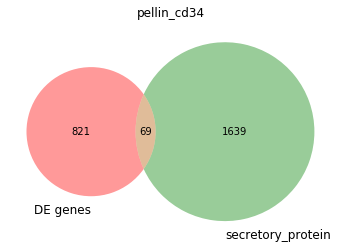

Fisher Exact: p-value = 0.21897245754881203
78 1630 886 22125


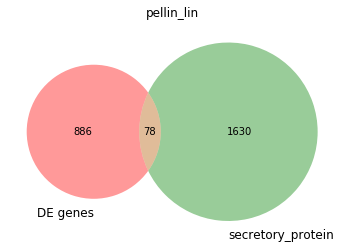

Fisher Exact: p-value = 0.15362225293225346
214 1494 978 14195


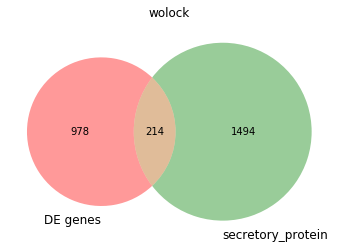

Fisher Exact: p-value = 1.0191006111188303e-17
186 1522 835 9446


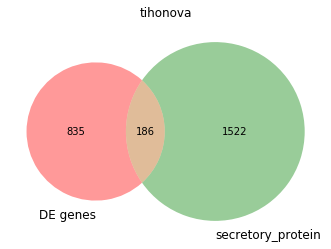

Fisher Exact: p-value = 0.0002537808718102573


In [51]:
de_sec_cd34, sec_34dict, p = wrapper(pellin_cd34, secreted_protein, 'secretory_protein', 'pellin_cd34')
de_sec_lin, sec_lindict,p = wrapper(pellin_lin, secreted_protein, 'secretory_protein', 'pellin_lin')
de_sec_wo, sec_wodict,p = wrapper(wo, secreted_protein, 'secretory_protein', 'wolock')
de_sec_tik, sec_tikdict,p = wrapper(tik, secreted_protein, 'secretory_protein', 'tihonova')

184 5336 706 19238


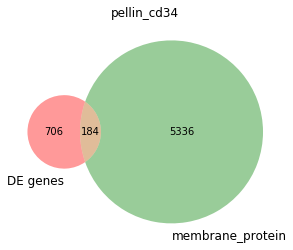

Fisher Exact: p-value = 0.48157680944007186
223 5297 741 18458


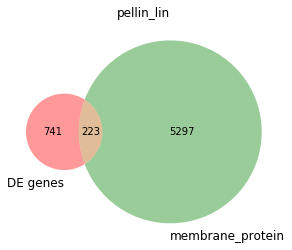

Fisher Exact: p-value = 0.5540367610303883
324 5196 868 10493


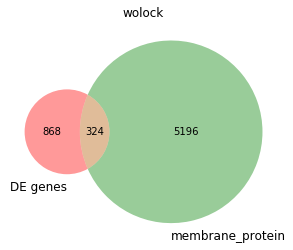

Fisher Exact: p-value = 2.0242434934367158e-05
296 5224 725 5744


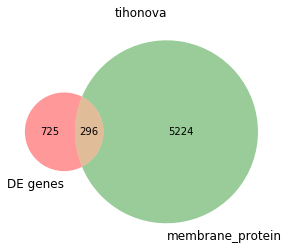

Fisher Exact: p-value = 3.066395626223312e-31


In [52]:
de_mem_cd34, mem_34dict,p = wrapper(pellin_cd34, membrane_protein, 'membrane_protein', 'pellin_cd34')
de_mem_lin, mem_lindict,p = wrapper(pellin_lin, membrane_protein, 'membrane_protein', 'pellin_lin')
de_mem_wo, mem_wodict,p = wrapper(wo, membrane_protein, 'membrane_protein', 'wolock')
de_mem_tik, mem_tikdict,p = wrapper(tik, membrane_protein, 'membrane_protein', 'tihonova')

In [15]:
def psuedotime_heatmap(gene_names, paths, adata):
    '''
    gene_names = a list of gene to plot
    paths = by louvain cluster
    adata = anndata containing single cell data
    '''
    import matplotlib.pyplot as plt
    _, axs = plt.subplots(ncols=len(paths), figsize=(12, 0.25*(len(gene_names)+2)), gridspec_kw={'wspace': 0.05, 'left': 0.12})
    plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
    for ipath, (descr, path) in enumerate(paths):
        _, data = sc.pl.paga_path(
            adata, path, gene_names,
            show_node_names=False,
            ax=axs[ipath],
            ytick_fontsize=12,
            left_margin=0.15,
            n_avg=50,
            annotations=['dpt_pseudotime'],
            show_yticks=True if ipath==0 else False,
            show_colorbar=False,
            color_map='coolwarm',
            color_maps_annotations={'distance': 'viridis'},
            title='{} path'.format(descr),
            return_data=True,
            show=False)
    

    plt.show()
    return(data)

In [63]:
def extract_along_pseudotime(adata, nodes, keys, path_name, n_avg = 400):
    '''
    extrac protein of interest along pseudotime along each branch
    '''
    dpt_df = sc.pl.paga_path(adata, nodes = nodes, keys = keys, use_raw = False, as_heatmap = False, n_avg = n_avg, return_data=True, show = False)
    dpt_df[1].to_csv(path_name+'_dpt_secmem.csv')
    
    return(dpt_df[1])
    

/home/hsher/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


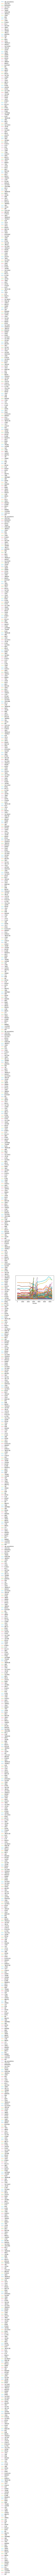

In [69]:
# output all pseudotime data along paths
lin_paths = [('Erythrocyte', [8,0,4,2,11,6,18]),
         ('Meg', [8,0,14,13]),
         ('Baso', [8,0,14,17]),
         ('Gran', [8,0,9,12,13]),
         ('Ly', [8,0,7])] 
for path in lin_paths:
    extract_along_pseudotime(pellin_lin, path[1], list(de_mem_lin)+list(de_sec_lin), path[0])

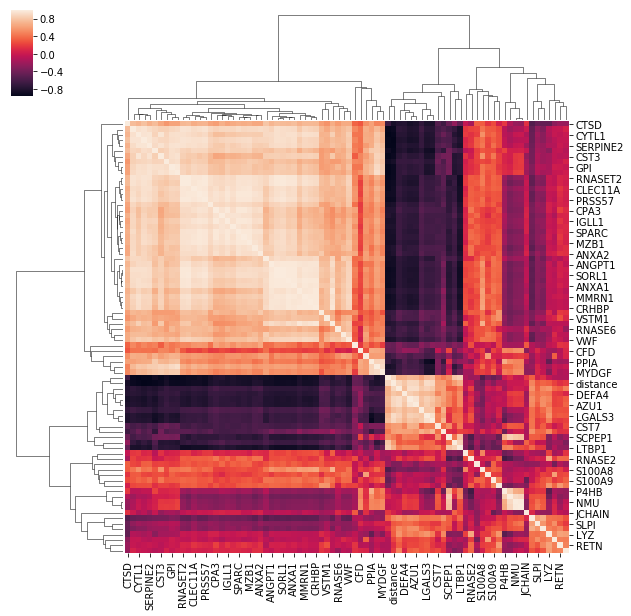

In [49]:
import seaborn as sns
sns.clustermap(de_sec_lin_dpt[1].corr())

In [16]:
cd34_paths = [('MEP-Meg', [0,2,10]),
         ('Meg-Erythro', [0,2,9,7]),
         ('CMP-gran', [0,1,4,8]),
         ('CMP-NK', [0,1,4,7]),
         ('CMP-Ly', [0,1,4,7])
        ]

NameError: name 'de_secP_all' is not defined